<a href="https://colab.research.google.com/github/czek0/Data-Science-Portfolio/blob/main/Covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I started by importing the following libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

import calendar

import holidays

import fbprophet
from fbprophet import Prophet

from neuralprophet import NeuralProphet

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

seed=42

ModuleNotFoundError: No module named 'fbprophet'

We can fetch the data from the official government github repository, where the data is updated daily at 18:00.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv', parse_dates=['data'])

<ipython-input-2-7a091153c9de>:1: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv', parse_dates=['data'])


In [3]:
df.tail()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,...,note,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido,codice_nuts_1,codice_nuts_2
32986,2024-06-12 17:00:00,ITA,19,Sicilia,38.115697,13.362357,59,2,61,929,...,NaN,0.0,NaN,NaN,543228.0,1291726.0,5504751.0,11468396.0,ITG,ITG1
32987,2024-06-12 17:00:00,ITA,9,Toscana,43.769231,11.255889,49,3,52,284,...,NaN,0.0,NaN,NaN,732753.0,921611.0,7154668.0,10252764.0,ITI,ITI1
32988,2024-06-12 17:00:00,ITA,10,Umbria,43.106758,12.388247,17,0,17,526,...,Si fa presente che dei 17 ricoveri non in T.I....,0.0,NaN,NaN,160703.0,298454.0,1765189.0,3418584.0,ITI,ITI2
32989,2024-06-12 17:00:00,ITA,2,Valle d'Aosta,45.737503,7.320149,5,0,5,6,...,NaN,0.0,NaN,NaN,16502.0,35984.0,146785.0,462337.0,ITC,ITC2
32990,2024-06-12 17:00:00,ITA,5,Veneto,45.434905,12.338452,169,8,177,9676,...,Si segnala che è presente un delta negativo re...,0.0,NaN,NaN,1150846.0,1691500.0,12241840.0,27245746.0,ITH,ITH3


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32991 entries, 0 to 32990
Data columns (total 30 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   data                                    32991 non-null  datetime64[ns]
 1   stato                                   32991 non-null  object        
 2   codice_regione                          32991 non-null  int64         
 3   denominazione_regione                   32991 non-null  object        
 4   lat                                     32991 non-null  float64       
 5   long                                    32991 non-null  float64       
 6   ricoverati_con_sintomi                  32991 non-null  int64         
 7   terapia_intensiva                       32991 non-null  int64         
 8   totale_ospedalizzati                    32991 non-null  int64         
 9   isolamento_domiciliare                  32991 non-

First, we convert the date column to pandas datetime format.

In [5]:
df['data'] = pd.to_datetime(df['data']).dt.normalize()

Moreover, we get today's and tomorrow's date, since they will be useful for future plots.

In [6]:
today = df['data'].iloc[-1]
tomorrow = today + pd.DateOffset(days=1)

Since the data is divided by region for each day, we create a new dataframe 'df_italy' where we group the rows by the column 'data' ( 'date' in english) to get the total daily data in Italy.

In [7]:
df_italy=df.groupby('data').sum()

## Covid19 during Holidays

In the following, we will define a 'holiday' column to include boolean values to check if a day is a holiday or not. We decided to include this column since, after a first analysis, it looks like that on days after holidays the number of new cases decreases, since on holidays usually less PCR tests are performed. By specifing this information to the prediction models, we can obtain a more accurate forecast.

We create a list compregension to extract the holidays from the holidays library, and add bolean values to a list is_holiday depending if the date is a holiday (value=1) or not (value=0).

In [9]:
is_holiday = [1 if x==True else 0 for x in [day in holidays.Italy() for day in df_italy.index]]
df_italy['holiday'] = is_holiday


## Weekly Distributions
Next we will analyze the weekly distribution to check how the mean, median and standard deviation of new cases changed during the weeks.
First, we create a list of the days for each date.



In [11]:
day = [calendar.day_name[day.weekday()] for day in df_italy.index]
df_italy['day'] = day
idx=0 #index to move along the rows
df_4weeks = pd.DataFrame() #empty dataframe
df_italy_small = df_italy.iloc[-34:].iloc[::-1] #consider 34 rows (worst case)

while(True):
    if df_italy_small.iloc[idx:].day[0] == 'Sunday':
        df_4weeks=df_italy_small.iloc[idx:idx+28]
        break
    else:
        idx+=1

df_week1=df_4weeks.iloc[:7]
df_week1['week']='1 week ago'

df_week2=df_4weeks.iloc[7:14]
df_week2['week']='2 weeks ago'

df_week3=df_4weeks.iloc[14:21]
df_week3['week']='3 weeks ago'

df_week4=df_4weeks.iloc[21:28]
df_week4['week']='4 weeks ago'

df_4weeks_2 = pd.concat([df_week1, df_week2, df_week3, df_week4])

mean_1 = np.round(df_week1.nuovi_positivi.mean(),0)
median_1 = np.round(df_week1.nuovi_positivi.median(),0)
std_1 = np.round(df_week1.nuovi_positivi.std(),0)

mean_2 = np.round(df_week2.nuovi_positivi.mean(),0)
median_2 = np.round(df_week2.nuovi_positivi.median(),0)
std_2 = np.round(df_week2.nuovi_positivi.std(),0)

mean_3 = np.round(df_week3.nuovi_positivi.mean(),0)
median_3 = np.round(df_week3.nuovi_positivi.median(),0)
std_3 = np.round(df_week3.nuovi_positivi.std(),0)

mean_4 = np.round(df_week4.nuovi_positivi.mean(),0)
median_4 = np.round(df_week4.nuovi_positivi.median(),0)
std_4 = np.round(df_week4.nuovi_positivi.std(),0)

<ipython-input-11-eef36de52527>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week1['week']='1 week ago'
<ipython-input-11-eef36de52527>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week2['week']='2 weeks ago'
<ipython-input-11-eef36de52527>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [12]:
df_stats = pd.DataFrame({'week':['1 week ago','2 weeks ago','3 weeks ago','4 weeks ago'],
                         'mean':[mean_1,mean_2,mean_3,mean_4],
                         'median':[median_1,median_2,median_3,median_4],
                         'std':[std_1,std_2,std_3,std_4]})
df_stats

,week,mean,median,std
0,1 week ago,228.0,244.0,78.0
1,2 weeks ago,176.0,189.0,48.0
2,3 weeks ago,133.0,146.0,40.0
3,4 weeks ago,137.0,112.0,79.0


<ipython-input-14-01fd58385dca>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=1`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='nuovi_positivi', data=df_week4, label='4 weeks ago', shade=1,ax=ax[0,0])
<ipython-input-14-01fd58385dca>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=1`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='nuovi_positivi', data=df_week3, label='3 weeks ago', shade=1,ax=ax[0,0])
<ipython-input-14-01fd58385dca>:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=1`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='nuovi_positivi', data=df_week2, label='2 weeks ago', shade=1,ax=ax[0,0])
<ipython-input-14-01fd58385dca>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=1`.
This will become an error in seaborn v0.14.0; plea

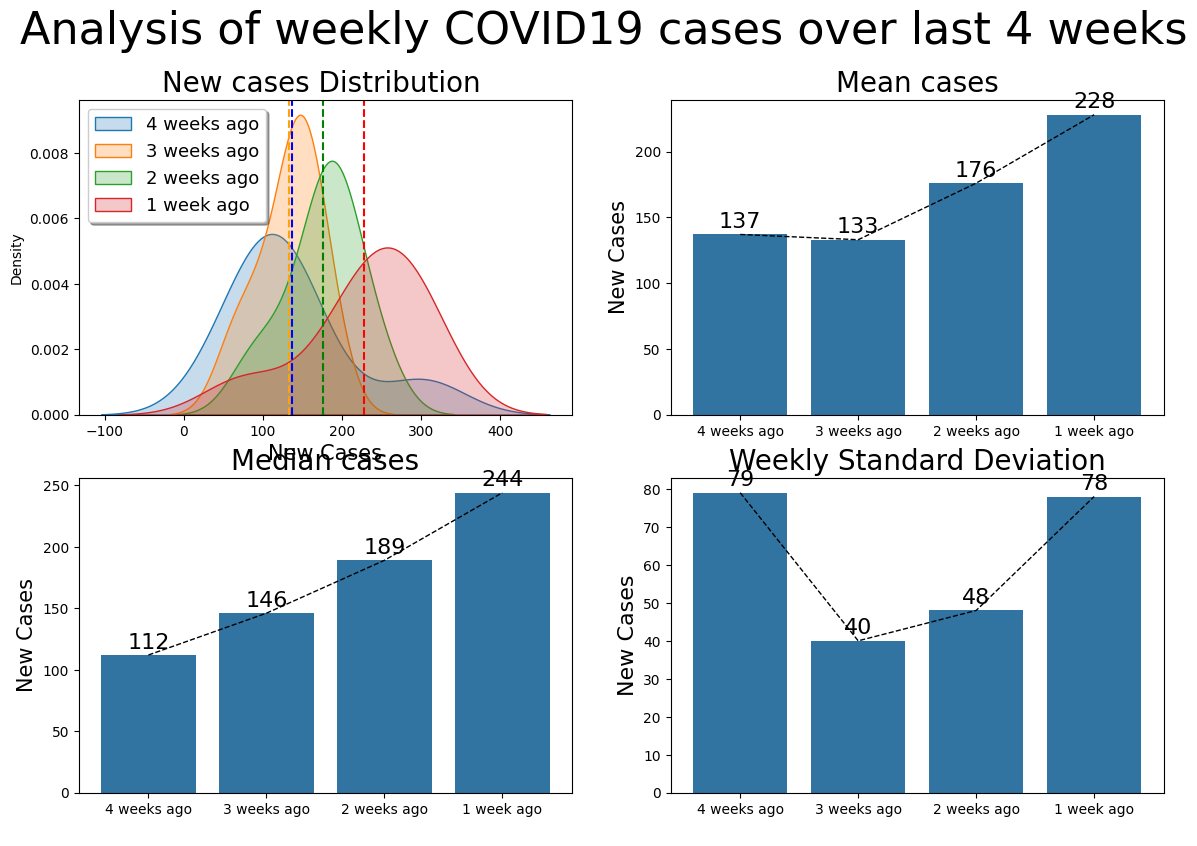

In [14]:
_, ax = plt.subplots(2,2,figsize=(14,9))
plt.suptitle('Analysis of weekly COVID19 cases over last 4 weeks', fontsize=32)

##PLOT 1

sns.kdeplot(x='nuovi_positivi', data=df_week4, label='4 weeks ago', shade=1,ax=ax[0,0])
sns.kdeplot(x='nuovi_positivi', data=df_week3, label='3 weeks ago', shade=1,ax=ax[0,0])
sns.kdeplot(x='nuovi_positivi', data=df_week2, label='2 weeks ago', shade=1,ax=ax[0,0])
sns.kdeplot(x='nuovi_positivi', data=df_week1, label='1 week ago', shade=1,ax=ax[0,0])

ax[0,0].axvline(mean_1, linewidth=1.5, color='red', linestyle='--')
ax[0,0].axvline(mean_2, linewidth=1.5, color='green', linestyle='--')
ax[0,0].axvline(mean_3, linewidth=1.5, color='orange', linestyle='--')
ax[0,0].axvline(mean_4, linewidth=1.5, color='blue', linestyle='--')

ax[0,0].legend(fontsize=13,fancybox=True, shadow=True, frameon=True, loc="upper left")
ax[0,0].set_xlabel('New Cases', fontsize=15)
ax[0,0].set_title('New cases Distribution ', fontsize=20)



##PLOT 2
g = sns.barplot(y='mean', x='week', data=df_stats.iloc[::-1] ,ax=ax[0,1], ci=False)
g.bar_label(g.containers[0], padding=2, fontsize=16, color='black')
sns.lineplot(y='mean', x='week', data=df_stats.iloc[::-1], ax=ax[0,1], ci=False, color='black',linewidth=1, linestyle='--')
ax[0,1].set_ylabel('New Cases', fontsize=15)
ax[0,1].set_xlabel(' ')
ax[0,1].set_title('Mean cases', fontsize=20)



##PLOT 3
g = sns.barplot(y='median', x='week', data=df_stats.iloc[::-1] ,ax=ax[1,0], ci=False)
g.bar_label(g.containers[0], padding=2, fontsize=16, color='black')
sns.lineplot(y='median', x='week', data=df_stats.iloc[::-1], ax=ax[1,0], ci=False, color='black',linewidth=1, linestyle='--')
ax[1,0].set_ylabel('New Cases', fontsize=15)
ax[1,0].set_xlabel(' ')
ax[1,0].set_title('Median cases', fontsize=20)



##PLOT 4
g = sns.barplot(y='std', x='week', data=df_stats.iloc[::-1] ,ax=ax[1,1], ci=False)
g.bar_label(g.containers[0], padding=2, fontsize=16, color='black')
sns.lineplot(y='std', x='week', data=df_stats.iloc[::-1], ax=ax[1,1], ci=False, color='black',linewidth=1, linestyle='--')
ax[1,1].set_ylabel('New Cases', fontsize=16)
ax[1,1].set_xlabel(' ')
ax[1,1].set_title('Weekly Standard Deviation', fontsize=20)


plt.show()